In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
import pandas as pd

from qmmc.variables import *

In [5]:
df = pd.read_csv("/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv")

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


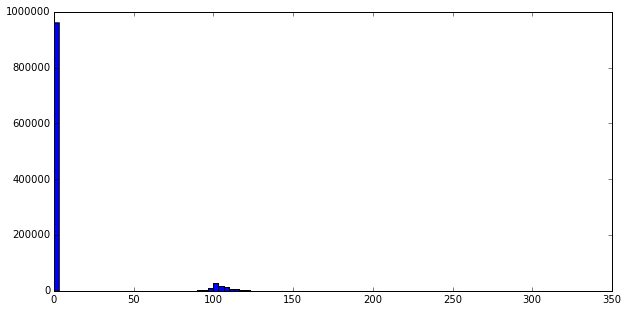

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(df["CoverPrice"], bins=100)
plt.show()

In [16]:
sum(df["CoverPrice"] > 50)

96478

In [4]:
idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"
df = df[idx_done + idx_traded_away + idx_not_traded]

df["Y"] = (df["BNPPAnsweredQuote"] - df["RFQCompositePrice"]) / np.abs(df["Bid2Mid"])
df = df[df["Y"] < 2]
df = df[df["Y"] > -2]

In [5]:
n = 1
dd = df[df["NbDealers"] == n + 1]

Y = Value(dd["Y"].values)

I = dd["TradeStatus"].values
II = np.empty(I.shape[0], dtype=int)
II[I == "Done"] = 2
II[I == "TradedAway"] = 1
II[I == "NotTraded"] = 0
II = Value(II)

In [6]:
mu_0, sigma_0 = Value(0), Value(3)
shape_0, scale_0 = Value(1), Value(1)
M = dd.shape[0]

mu_V = Normal(mu_0, sigma_0, value=0, name='mu_V')
sigma_V = InvGamma(shape_0, scale_0, value=2, name='sigma_V')
V = Normal(mu_V, sigma_V, size=M, name='V')

mu_W = Normal(mu_0, sigma_0, value=0, name='mu_W')
sigma_W = InvGamma(shape_0, scale_0, value=2, name='sigma_W')
W = Normal(mu_W, sigma_W, size=(M, n), name='W')

@Function
def S(V=V, W=W, Y=Y):
    m = np.min(W, axis=1)
    idx_not_traded = np.minimum(m, Y) > V
    idx_traded_away = m <= Y
    idx_done = m > Y
    
    s = np.empty(V.shape[0], dtype=int)
    s[idx_done] = 2
    s[idx_traded_away] = 1
    s[idx_not_traded] = 0
    return s

p = Value(0.01)
I = BernoulliFlip(p, S, value=II.value)

In [7]:
print S.value[:50]
print I.value[:50]

[2 0 1 0 0 0 2 1 1 2 1 2 1 1 1 0 2 0 1 0 1 1 0 1 2 1 0 0 0 0 1 2 2 1 2 0 0
 1 2 2 0 2 2 2 1 0 2 2 0 0]
[2 2 0 2 0 2 0 0 0 2 1 0 0 0 0 2 2 1 0 0 0 2 0 1 0 0 2 2 0 0 0 2 2 1 0 0 2
 2 0 2 0 0 0 0 2 2 0 1 2 0]


In [8]:
print mu_V.value, sigma_V.value
print mu_W.value, sigma_W.value

0 2
0 2


In [9]:
model = Model([mu_V, sigma_V, V, mu_W, sigma_W, W, S, I])

In [10]:
model.estimate(1000)

In [11]:
print mu_V.value, sigma_V.value
print mu_W.value, sigma_W.value

-0.0712220192497 -0.130123141767
-0.0082179544119 -0.154188000083


In [12]:
mu_V_samples = model.samplers['mu_V'].get_history()
sigma_V_samples = model.samplers['sigma_V'].get_history()
mu_W_samples = model.samplers['mu_W'].get_history()
sigma_W_samples = model.samplers['sigma_W'].get_history()

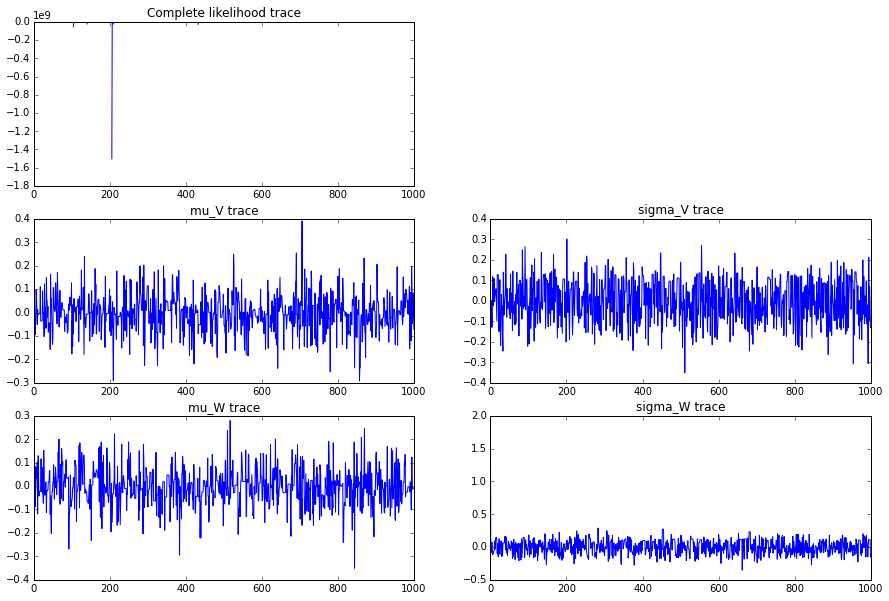

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(3, 2, 3)
plt.plot(mu_V_samples)
plt.title("mu_V trace")
plt.subplot(3, 2, 4)
plt.plot(sigma_V_samples)
plt.title("sigma_V trace")

plt.subplot(3, 2, 5)
plt.plot(mu_W_samples)
plt.title("mu_W trace")
plt.subplot(3, 2, 6)
plt.plot(sigma_W_samples)
plt.title("sigma_W trace")

In [16]:
len(model.logp_history)

1000